# Introduction to the Tranbjerg sewer pipe dataset and scripts

Author: Chris Holmberg Bahnsen, cb@create.aau.dk

Last revision: March 29th, 2022



    
   
    
    
    



## Dataset
The dataset from the Tranbjerg recordings of sewer pipes is located at:
- http://aau-asir-nas.quickconnect.to/d/s/o45sdXN54chkK9zPqmAnbm70YpEBJzDP/WcAL5bx8WA7K_eoZUQ59nDJNdWAgnIJC-n74gZbXYZwk
- Password: Retrieved upon request
- Link expires: December 31st, 2022.



The folder structure of the data directory is as follows:
PipeMaterial -> PipeType -> SensorPlacement -> PipeClass -> PipeSize -> Recordings

- **PipeMaterial**: Physical material of the investigated pipe: {Concrete, PVC}
- **PipeType**: What is the pipe used for? {Rain, Sewer}
- **SensorPlacement**: How is the measurement box placed in the pipe: {Middle, Top}
- **Pipe Class**: What diameter is the pipe from the look at the map? {mm}
- **Pipe Size**: What is the measured diameter by a trained professional? {mm}
- **Recordings**: The data folder containing the raw recorded sensor data for a particular recording

The **Recordings** folder contains the following:
- **data.pickle**: Raw sensor data of the recording. Containg data from the PMD CamBoard pico flexx time-of-flight camera and the Realsense D435i stereo camera.
- **meta.pickle**: Containing meta data of the sensors such as the intrinsic camera calibration parameters.
- **data-img**: folder containing color images from the Realsense D435i.
- **data-ply**: folder containing point clouds extracted from the depth images of the Realsense and pico flexx cameras.




## Scripts

### Data extraction from pickle files
The file `pickle-to-ply.py` extracts point cloud (ply) and image files from the raw pickle files. The script may be run as follows:
```
python pickle-to-ply.py --rootfolder="Path To Data Folder"
```

### Cylinder estimation from point clouds
We use the PointCloudLibrary (PCL) for cylinder estimation on point clouds. The code is written in C++ and is found in `PCL_ransac/PCL_ransac.cpp`. Specifically, the cylinder estimation is based on the [SACSegmentationFromNormals](https://pointclouds.org/documentation/classpcl_1_1_s_a_c_segmentation_from_normals.html) method. 

An executable build file for Windows is found in `PCL_ransac/build/` along with the necessary dependencies.

The executable can be run from the command line with the following arguments:
```
PCL_ransac.exe data_folder inlier_distance max_z_distance --gui --no_transform
```

Arguments:
- **data_folder** Base data folder. This folder, and all sub-folders, will be searched for .ply files to use for the estimation. 
- **inlier_distance**: Inlier distance threshold {m} used in the RANSAC-based cylinder estimation.
- **max_z_distance**: Depth cut-off {m} at which the point cloud is cropped
- **--gui** If set, intermediate views of the point cloud will be shown
- **--transform** If set, the point cloud will be transformed such that the principal axis of the estimated cylinder is the new z-axis of the copied point cloud.

Once run, `PCL_ransac` will create a file named ``radiiandmse.csv`` in the **data_folder** directory, containing the main estimated information for each point cloud. 
At the location of each point cloud, `PCL_ransac` will create a .txt-file containing the parameters of the estimated cylinder:
- **Radii:** Radius of the estimated cylinder
- **a:**: The direction of the principal axes of the estimated cylinder
- **pstar**: A point on the cylinder axis


### Interpreting the cylinder estimates

#### analyseCsvData.py
The file `analyseCsvData.py` contains methods for interpreting and analyzing the `radiiandmse.csv` file generated from `PCL_ransac`. 
The two most important methods are:
- `calculateConsensusData`: Aggregates radius estimates from individual frames of the same recording to calculate a consensus radius estimate. For each recording, we may have 50 point clouds from the same sensor. `PCL_ransac` will calculate a (noisy) radius estimate for the point cloud of each frame. We want to calculate a more stable radius estimate. Furthermore, we want to aggregate information on the performance of the RANSAC algorithm, e.g. the number of inliers used for the estimation and the mean squared error (MSE) of the estimation. The method will output a file named `*-analysis.csv` containing the following information for each recording:
    - **wellType**
    - **position**
    - **groundTruthRadius**
    - **timestamp**
    - **cameraType** {realsense,pico}
    - **{radiiMean, radiiMedian, radiiStd, radiiSkew}**: Mean/Median/standard deviation/skewness of the radius estimate over the recorded *n* frames. Currently, we use the median for estimating the radius of the pipe.
    - **radiiWeighted**: Weighted radius based on the inlier percentage of a given frame. Not used.
    - **{mseMean, mseMedian, mseStd, mseSkew}**: Mean/Median/standard deviation/skewness of the MSE of the cylinder fitting over the recorded *n* frames. Used for the possible filtering of bad radius estimates.
    - **{meanPercentInliers, medianPercentInliers, percentInliersStd, skewPercentInliers}**: Mean/Median/standard deviation/skewness of the inliers percentage of the RANSAC fitted cylinder over the recorded *n* frames. Used for the possible filtering of bad radius estimates.
    - **zeroBasedInliers** Attempt at making an alternative metric based. Not used. See lines 79-83 for more info.
    - **{numberPointsMean, numberPointsMedian, numberPointsStd}**: Mean/Median/standard deviation of the number of points counting as inliers for the RANSAC cylinder estimate over the recorded *n* frames.
    - **{circlePct\*, cylOrientation\*}**: Attempt at creating additional metrics for the filtering of the radius estimates. Not used.
- `summarizeConsensusDataAcrossThresholds`: Takes the consensus data calculated above and compare the data across different inlier thresholds. Used to shed light on the following questions:
    - Which inlier threshold for the RANSAC estimation is the better threshold?
    - Which consensus estimate of the radius is better? {radiiMean/RadiiMedian)
    - Which camera is producing better estimates? {pico flexx/Realsense}


#### plotter.py
The file `plotter.py` mainly consists of a range of plotting methods for producing journal-grade figures in Matplotlib. The most important methods are:
- `getSetsFromFile`: Not plotting anything. Retrieves data from the csv file produced by `PCL_ransac`. Frequently called by other methods.
- `plotEstimationErrorAcrossThresholds`: Used for producing the following plot: 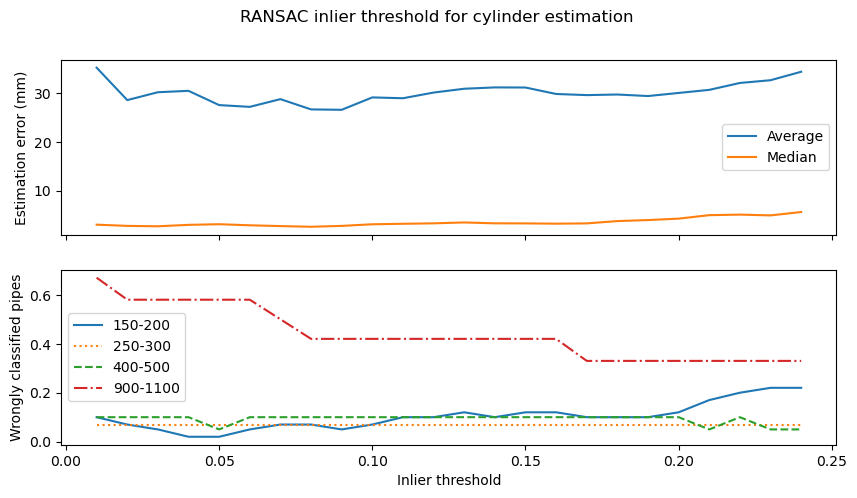
- `plotProxyErrorEstimators`. Used for producing the following plot that investigates the use of the radiiStd to filter bad radius estimates:
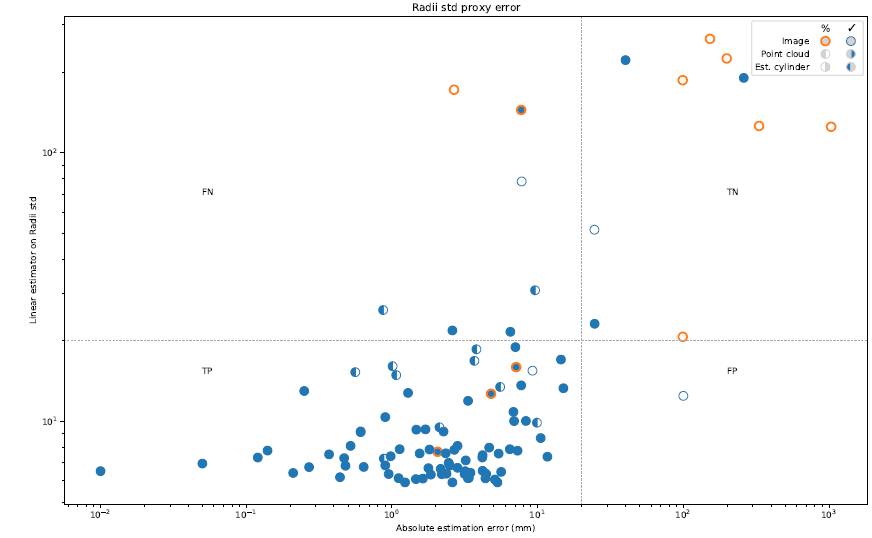
- `crossMetricPlots`: Used for visualizing random frames of each recording along with the estimated cylinder and frame-based information of the stability of the radius estimate. Examples: 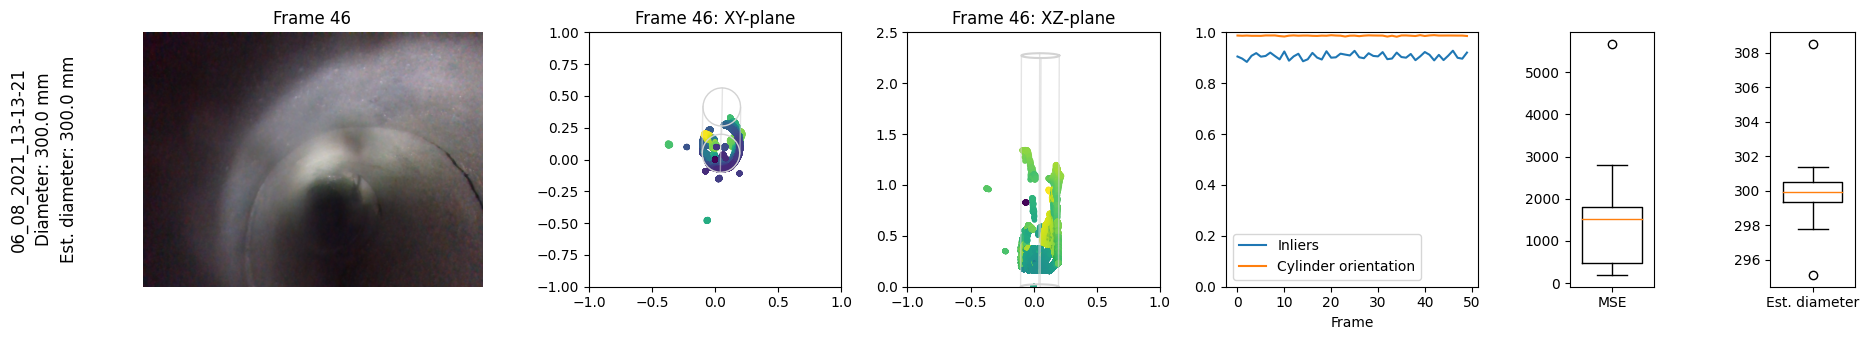
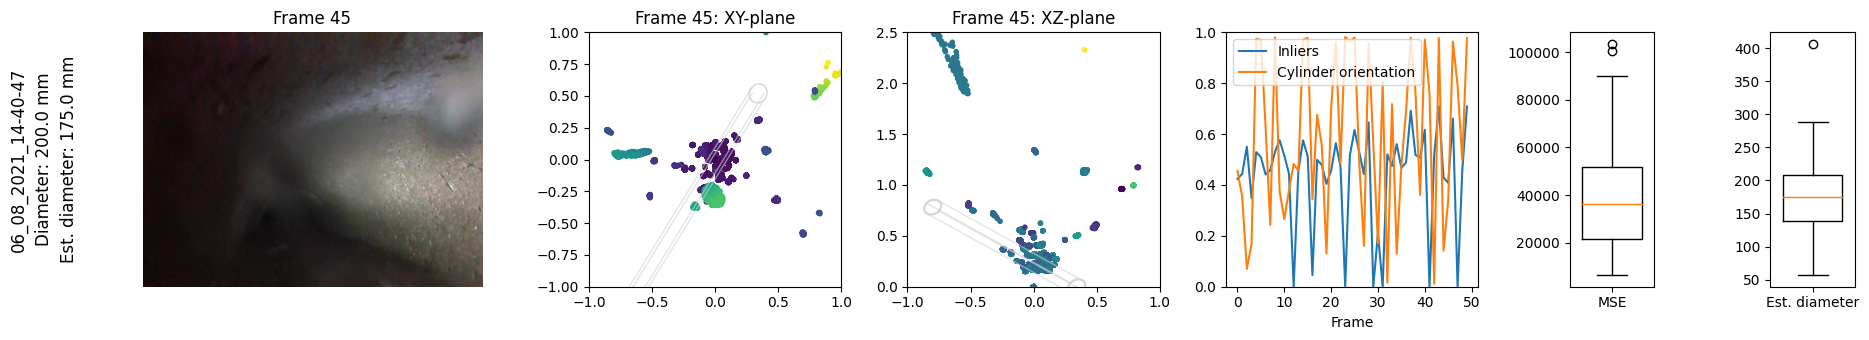
